In [1]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if "/home/alex/qi3/hmmtuf" not in sys.path:
    sys.path.append("/home/alex/qi3/hmmtuf")

In [3]:
from db.sqlite3_db_connector import SQLiteDBConnector
from compute_engine.src.utils import count_kmers
from compute_engine.src.utils import INFO

In [4]:
# connect to the DB
db_connector = SQLiteDBConnector(db_file="../../play_ground.sqlite3")

In [5]:
MIN_REPEAT_LENGTH = 10
N_BEST_COUNTS = 5
KMER_LENGTH = 4

In [6]:
def get_max_kmers(kmers, min_count):
    
    
    # sort the dictionary
    sorted_kmers = {k: v for k, v in sorted(kmers.items(), key=lambda item: item[1], reverse=True)}
    
    top_kmers = dict()
    
    counter = 0
    for item in sorted_kmers:
        
        if counter < min_count:
            top_kmers[item] = sorted_kmers[item]
            counter += 1
        else:
            break
        
    return top_kmers

In [7]:
def insert_or_update(kmers_old, kmers_new):
    
    for item in kmers_new:
        if item in kmers_old:
            kmers_old[item] += kmers_new[item]
        else:
            kmers_old[item] = kmers_new[item]
            

In [8]:
tbl_names = db_connector.get_table_names()

print("{0} DB table names: {1}".format(INFO, tbl_names))

INFO: DB table names: ['distance_metric_type', 'distance_sequence_type', 'repeats', 'hmm_state_types', 'repeats_distances', 'repeats_info', 'gquads_info']


In [9]:
print(db_connector.get_table_column_names(table_name='repeats'))

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'chromosome', 'TEXT', 1, None, 0), (2, 'start_idx', 'INT', 1, None, 0), (3, 'end_idx', 'INT', 1, None, 0), (4, 'repeat_seq', 'TEXT', 1, None, 0), (5, 'hmm_state_id', 'INTEGER', 1, None, 0), (6, 'gc', 'FLOAT', 0, None, 0)]


In [10]:
# repeat sequences and their state
sql = "SELECT repeats.id, repeats.repeat_seq,  hmm_state_types.type FROM repeats \
JOIN hmm_state_types WHERE repeats.hmm_state_id=hmm_state_types.id AND length(repeats.repeat_seq) > {0}".format(MIN_REPEAT_LENGTH)

In [11]:
repeats = db_connector.fetch_all(sql=sql)

In [12]:
print("{0} Number of repeats={1}".format(INFO, len(repeats)))

INFO: Number of repeats=1896


In [13]:
total_kmers = {}

In [14]:
count = 0
hmm_states = set()
for repeat in repeats:
    
    repeat_id = repeat[0]
    repeat_seq = repeat[1]
    kmers = count_kmers(sequence=repeat_seq, k=KMER_LENGTH)
    top_kmers = get_max_kmers(kmers=kmers, min_count=N_BEST_COUNTS)
    
    total_kmers[repeat_id] = (top_kmers, repeat[2])
    hmm_states.add(repeat[2])  

In [15]:
print("{0} HMM states {1}".format(INFO, hmm_states))

INFO: HMM states {'DELETION', 'NORMAL', 'TUF'}


In [16]:
# arrange kmers according to HMM state
hmm_kmers = {}

for state in hmm_states:
    hmm_kmers[state] = dict()

for item in total_kmers:
    item_data = total_kmers[item] 
    insert_or_update(kmers_old=hmm_kmers[item_data[1]], kmers_new=item_data[0])
        

In [17]:
for state in hmm_kmers:
    print("{0} state {1} has {2} kmers".format(INFO, state, len(hmm_kmers[state])))

INFO: state DELETION has 208 kmers
INFO: state NORMAL has 216 kmers
INFO: state TUF has 245 kmers


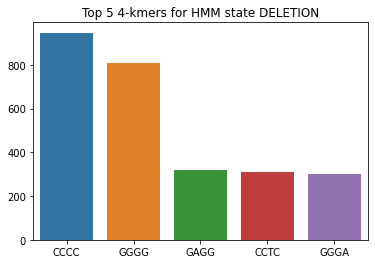

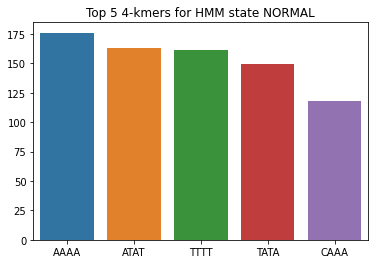

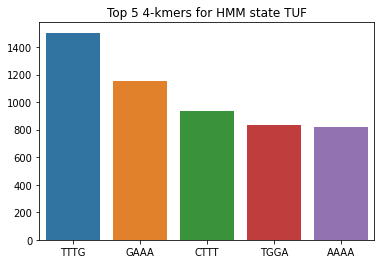

In [18]:
# get top five kmers
top_best_kmers = {}

for state in hmm_kmers:
    top_state_kmers = get_max_kmers(hmm_kmers[state], min_count=N_BEST_COUNTS)
    #top_best_kmers[state] = top_state_kmers
    
    kmer_names = [name for name in top_state_kmers]
    frequencies = [top_state_kmers[item] for item in top_state_kmers]
    sns.barplot(x=kmer_names, y=frequencies)# palette=clrs)
    plt.title("Top {0} {1}-kmers for HMM state {2}".format(N_BEST_COUNTS, KMER_LENGTH, state))
    plt.show()

In [19]:
categories = {'C1': {"R": ['A', 'G'], "Y": ["C", "T"]},
              'C2': {"M": ['A', 'C'], "K": ["G", "T"]},
              'C3': {"W": ['A', 'T'], "S": ["C", "G"]}}

In [20]:
def map_seq_to_category(category, seq):
    """
    project the original seq into
    the given category
    """

    new_seq = ''
    g1 = category[list(category.keys())[0]]
    g2 = category[list(category.keys())[1]]

    for base in seq:

        if base in g1:
            new_seq += list(category.keys())[0]
        elif base in g2:
            new_seq += list(category.keys())[1]
        else:
            raise ValueError("base {0} not in {1} or in {2}".format(base, g1, g2))
    return new_seq

In [21]:
old_seq = repeats[0][1]
print("{0} Old sequence {1}".format(INFO, old_seq))

new_seq = map_seq_to_category(categories["C1"], seq=old_seq)
print("{0} Mapped sequence {1}".format(INFO, new_seq))

INFO: Old sequence CGGGGACTCTCTCTCTCTCCCGGGGCAGGTGGGGCTCTC
INFO: Mapped sequence YRRRRRYYYYYYYYYYYYYYYRRRRYRRRYRRRRYYYYY


In [22]:
count = 0
total_kmers_per_category = {}
for repeat in repeats:
    
    repeat_id = repeat[0]
    repeat_seq = repeat[1]
    total_kmers_per_category[repeat_id] = {}
    for c in categories:
        
        kmers = count_kmers(sequence=map_seq_to_category(categories[c], seq=repeat_seq), k=KMER_LENGTH)
        top_kmers = get_max_kmers(kmers=kmers, min_count=N_BEST_COUNTS)
    
        total_kmers_per_category[repeat_id][c] = (top_kmers, repeat[2])
    

In [23]:
# arrange kmers according to HMM state and category
hmm_kmers_category = {}

for state in hmm_states:
    hmm_kmers_category[state] = dict()
    
    for c in categories:
        hmm_kmers_category[state][c] = dict()
        

for item in total_kmers_per_category:
    for c in categories:
    
        item_data = total_kmers_per_category[item][c]
        insert_or_update(kmers_old=hmm_kmers_category[item_data[1]][c], kmers_new=item_data[0])

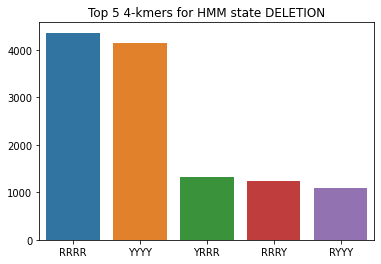

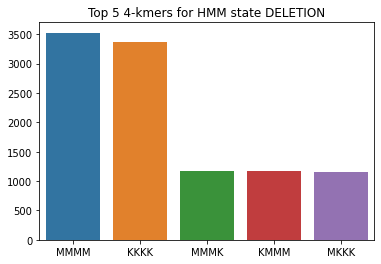

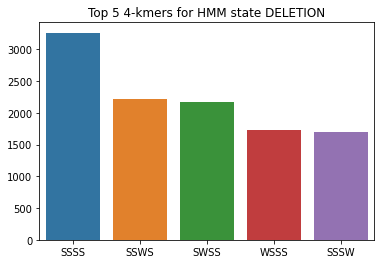

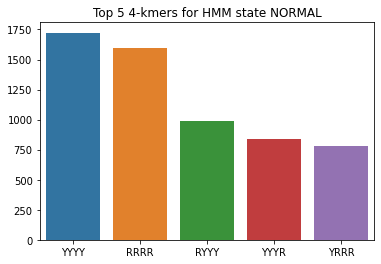

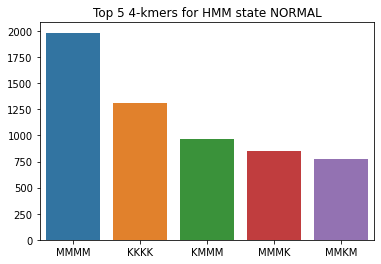

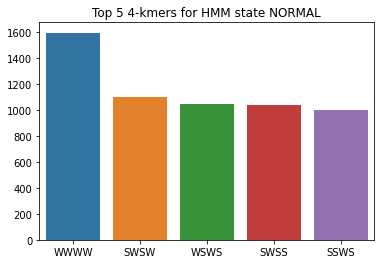

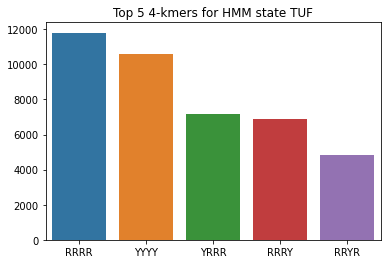

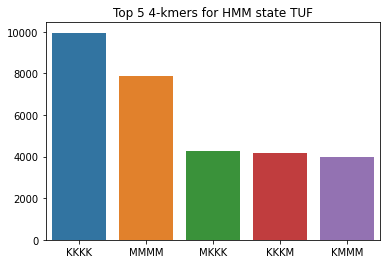

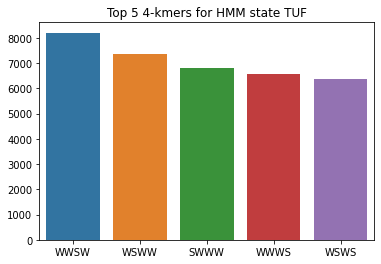

In [24]:
# get top five kmers
top_best_kmers = {}

for state in hmm_kmers_category:
    
    #fig, axs = plt.subplots(ncols=3)
    #fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
    #fig.subplots_adjust(hspace=0.1, wspace=0.2)
    
    for i, c in enumerate(categories):
    
        top_state_kmers = get_max_kmers(hmm_kmers_category[state][c], min_count=N_BEST_COUNTS)
    
        kmer_names = [name for name in top_state_kmers]
        frequencies = [top_state_kmers[item] for item in top_state_kmers]
        
        #ax = sns.barplot(x=kmer_names, y=frequencies, ax=axs[i])
        sns.barplot(x=kmer_names, y=frequencies) #, ax=axs[i])
        
        
        plt.title("Top {0} {1}-kmers for HMM state {2}".format(N_BEST_COUNTS, KMER_LENGTH, state))
        plt.show()